Epoch 100, Loss: 961004.625
Epoch 200, Loss: 939785.625
Epoch 300, Loss: 921220.75
Epoch 400, Loss: 903627.625
Epoch 500, Loss: 886620.5
Epoch 600, Loss: 870046.25
Epoch 700, Loss: 853826.75
Epoch 800, Loss: 837916.0
Epoch 900, Loss: 822283.75
Epoch 1000, Loss: 806909.25
Epoch 1100, Loss: 791776.75
Epoch 1200, Loss: 776874.3125
Epoch 1300, Loss: 762192.25
Epoch 1400, Loss: 747722.25
Epoch 1500, Loss: 733457.875
Epoch 1600, Loss: 719392.875
Epoch 1700, Loss: 705522.4375
Epoch 1800, Loss: 691842.0625
Epoch 1900, Loss: 678347.25
Epoch 2000, Loss: 665034.75
Epoch 2100, Loss: 651901.0
Epoch 2200, Loss: 638942.9375
Epoch 2300, Loss: 626157.75
Epoch 2400, Loss: 613542.75
Epoch 2500, Loss: 601095.625
Epoch 2600, Loss: 588814.125
Epoch 2700, Loss: 576695.875
Epoch 2800, Loss: 564739.375
Epoch 2900, Loss: 552942.375
Epoch 3000, Loss: 541303.25
Epoch 3100, Loss: 529820.5625
Epoch 3200, Loss: 518492.625
Epoch 3300, Loss: 507318.0
Epoch 3400, Loss: 496295.3125
Epoch 3500, Loss: 485423.28125
Epoch 3

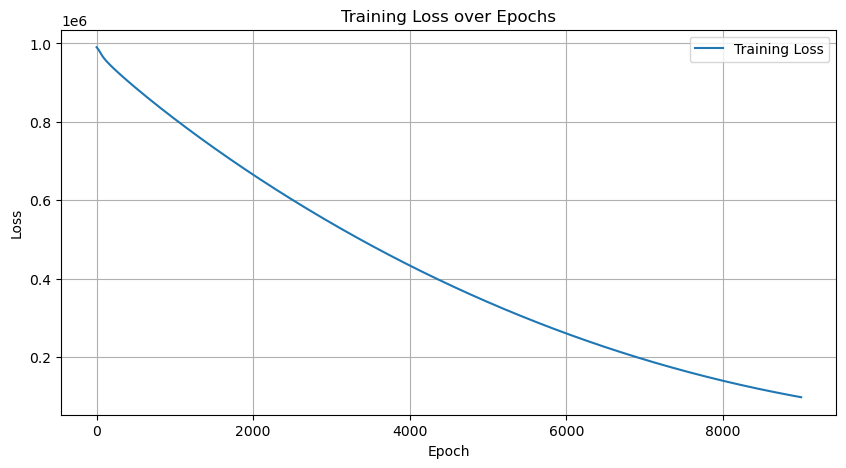

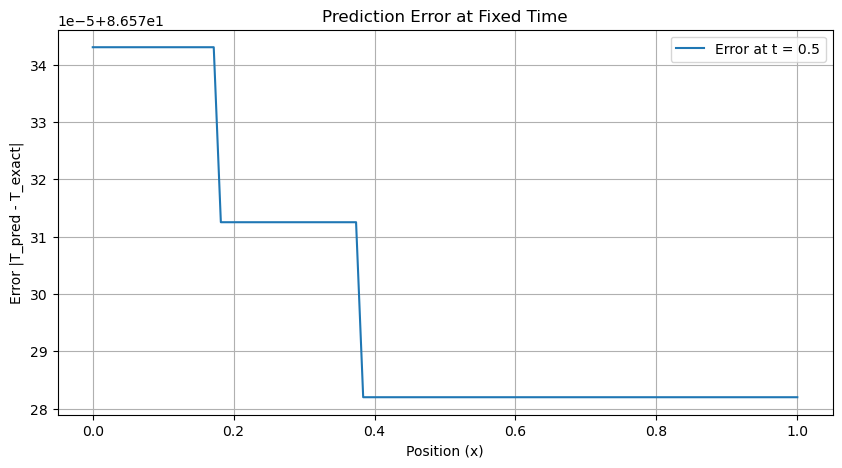

In [84]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network architecture
class HeatPINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(HeatPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, t):
        input_features = torch.cat([x, t], dim=1)
        return self.net(input_features)

# Hyperparameters
hidden_size = 50
learning_rate = 1e-3
epochs = 9000
alpha = 0.01  # Adjust this value based on your problem

# Initialize the model
model = HeatPINN(input_size=2, hidden_size=hidden_size, output_size=1)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training data preparation
x = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
t = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
X = X.reshape(-1, 1)
T = T.reshape(-1, 1)

# Record losses for plotting
epoch_losses = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Predict temperature
    T_pred = model(X, T)

    # Compute PDE residual
    T_pred = T_pred.reshape(X.shape)
    T_pred_t = torch.autograd.grad(T_pred, T, torch.ones(T.shape, device=T_pred.device), create_graph=True)[0]
    T_pred_xx = torch.autograd.grad(T_pred, X, torch.ones(X.shape, device=T_pred.device), create_graph=True)[0]
    T_pred_xx = torch.autograd.grad(T_pred_xx, X, torch.ones(X.shape, device=T_pred.device), create_graph=True)[0]
    
    # PDE Loss
    pde_residual = T_pred_t - alpha * T_pred_xx
    pde_loss = torch.mean(pde_residual ** 2)
    
    # Boundary condition loss
    # Adjust boundary tensors to have the same size in the time dimension as T
    left_boundary = torch.zeros(T.shape, device=X.device, requires_grad=True)
    right_boundary = torch.ones(T.shape, device=X.device, requires_grad=True)

    bc_loss = torch.mean((model(left_boundary, T) - 500) ** 2) \
            + torch.mean((model(right_boundary, T) - 500) ** 2)
    
    # Initial condition loss
    ic_loss = torch.mean((model(X, torch.zeros_like(T)) - 700) ** 2)

    # Total loss
    loss = pde_loss + bc_loss + ic_loss
    epoch_losses.append(loss.item())
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the error for a fixed time
t_fixed = torch.tensor([[0.5]] * 100, requires_grad=True)  # Choose a time to observe error
x_values = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
exact_solution = 500  # If you have an exact solution function, apply it here

T_pred_fixed_time = model(x_values, t_fixed).detach().numpy().flatten()
error_at_fixed_time = np.abs(T_pred_fixed_time - exact_solution)

plt.figure(figsize=(10, 5))
plt.plot(x_values.detach().numpy(), error_at_fixed_time, label='Error at t = 0.5')
plt.xlabel('Position (x)')
plt.ylabel('Error |T_pred - T_exact|')
plt.title('Prediction Error at Fixed Time')
plt.legend()
plt.grid(True)
plt.show()
